<IPython.core.display.Javascript object>


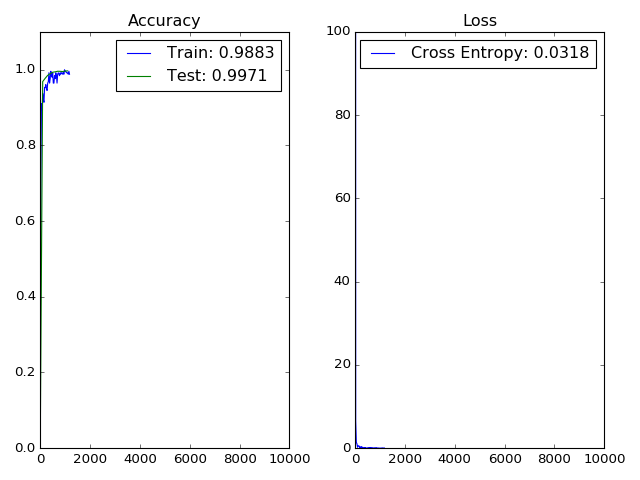

15471
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
step 0, training accuracy 0.175781
step 25, training accuracy 0.714844
step 50, training accuracy 0.910156
step 75, training accuracy 0.894531
step 99, test accuracy 0.96878
Model saved in file: 10000-256-0.001-model.ckpt
step 100, training accuracy 0.9375
step 125, training accuracy 0.921875
step 150, training accuracy 0.914062
step 175, training accuracy 0.953125
step 199, test accuracy 0.977506
Model saved in file: 10000-256-0.001-model.ckpt
step 200, training accuracy 0.953125
step 225, training accuracy 0.960938
step 250, training accuracy 0.949219
step 275, training accuracy 0.945312
step 299, test accuracy 0.985263
Model saved in file: 10000-256-0.001-model.ckpt
step 300, training accuracy 0.964844
step 325, training accuracy 0.96875
step 350, training 

KeyboardInterrupt: 

In [1]:
from __future__ import print_function

%matplotlib notebook 

import tensorflow as tf
import numpy as np

from os.path import join
from helper_functions import *
from visualization import Visualization
from sklearn.model_selection import train_test_split

EPOCHS = 10000
LEARNING_RATE = 1e-3
BATCH_SIZE = 256

def weight_variable(shape):
    with tf.name_scope('weights'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        weight = tf.Variable(initial)
        variable_summaries(weight)
        return weight

def bias_variable(shape):
    with tf.name_scope('biases'):
        initial = tf.constant(0.1, shape=shape)
        bias = tf.Variable(initial)
        variable_summaries(bias)
        return bias
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


class DigitClassifier():
    def __init__(self, data, filter_type='original'):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        viz = Visualization(epochs=EPOCHS)
        _x_data, _y_data = collect_images(data, filter_type)                
        target = np.zeros((len(_y_data), 10))
        target[np.arange(len(_y_data)),_y_data] = 1
        self._y_data = target
        x_train, x_test, self.y_train, self.y_test = train_test_split(_x_data,self._y_data,random_state=42)
        self._num_examples = len(x_train)
        print(len(x_train))
        
        # Flatten training images
        n_samples = len(x_train)
        self.x_train = x_train.reshape((n_samples,-1))
        n_samples = len(x_test)
        self.x_test = x_test.reshape((n_samples,-1))        
        
        # Get flattened test images
        self.test_images = self.get_test_images(self.x_test)    
        
        # Explicitly initialize new graph
        tf.Graph()
        
        # Initialize input and target tensors
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')
            tf.add_to_collection('x-input', x)
            tf.add_to_collection('y-input', y_)
        
        # Initialize weight and bias tensors
        with tf.name_scope('convolutional_layer_1'):
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
        
        with tf.name_scope('input_reshape'):
            x_image = tf.reshape(x, [-1,28,28,1])
            tf.summary.image('input', x_image, 10)
            
        with tf.name_scope('convolutional_layer1'):
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
            
        with tf.name_scope('pooling_layer_1'):
            h_pool1 = max_pool_2x2(h_conv1)
        
        with tf.name_scope('convolutional_layer_2'):
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])        
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        
        with tf.name_scope('pooling_layer_2'):
            h_pool2 = max_pool_2x2(h_conv2)
            
        with tf.name_scope('fully_connected_layer_1'):
            W_fc1 = weight_variable([7 * 7 * 64, 512])
            b_fc1 = bias_variable([512])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        with tf.name_scope('dropout'):
            keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            tf.add_to_collection('keep_prob', keep_prob)
            tf.summary.scalar('dropout_keep_probability', keep_prob)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)                    

        with tf.name_scope('fully_connected_layer_2'):
            W_fc2 = weight_variable([512, 10])
            b_fc2 = bias_variable([10])
            self.y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            tf.add_to_collection("y_conv", self.y_conv)

        with tf.name_scope('cross_entropy'):
            # The raw formulation of cross-entropy,
            #
            # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
            #                               reduction_indices=[1]))
            #
            # can be numerically unstable.
            #
            # So here we use tf.nn.softmax_cross_entropy_with_logits on the
            # raw outputs of the nn_layer above, and then average across
            # the batch.
            
            diff = tf.nn.softmax_cross_entropy_with_logits(self.y_conv, y_)
            with tf.name_scope('total'):
                cross_entropy = tf.reduce_mean(diff)

        tf.summary.scalar('cross_entropy', cross_entropy)
        tf.add_to_collection('cross_entropy', cross_entropy)
        
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
            tf.add_to_collection('train_op', self.train_step)

        with tf.name_scope('accuracy'):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(self.y_conv, 1), tf.argmax(y_, 1))
                tf.add_to_collection('correct_prediction', correct_prediction)
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.add_to_collection('accuracy', accuracy)
        tf.summary.scalar('accuracy', accuracy)
        
        sess = tf.Session()
        # Add an op to initialize the variables.
        self.init_op = tf.global_variables_initializer()

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        sess.run(self.init_op)
        
        # Merge all the summaries and write them out to /logs
        dir_path = os.path.abspath('')
        log_dir=join(dir_path,'logs-' + str(EPOCHS) + '-' + str(BATCH_SIZE) + '-' + str(LEARNING_RATE))        
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(join(log_dir,'train'),
                                      sess.graph)
        test_writer = tf.summary.FileWriter(join(log_dir,'test'))
        
        best_accuracy = 0.95
        for epoch in range(EPOCHS):
            batch = self.next_batch(BATCH_SIZE)    
            summary, _, acc, cross_entropy_loss = sess.run([merged, self.train_step, accuracy, cross_entropy], feed_dict={x : batch[0], y_ : batch[1], keep_prob: 0.5})
            
            if epoch % 100 == 99: # Record train set summaries, and test                
                run_metadata = tf.RunMetadata()
                train_writer.add_run_metadata(run_metadata, 'step%03d' % epoch)

                # Add training summary
                train_writer.add_summary(summary, epoch)
                                
                summary, test_accuracy, cross_entropy_loss = sess.run([merged, accuracy, cross_entropy], feed_dict={x : self.test_images, y_ : self.y_test, keep_prob: 1.0})
                print("step %d, test accuracy %g"%(epoch, test_accuracy))
                viz(epoch, test=test_accuracy, cross_entropy=cross_entropy_loss)
                test_writer.add_summary(summary, epoch)
                if test_accuracy > best_accuracy:
                    # Save the variables to disk.
                    save_path = saver.save(sess, str(EPOCHS) + "-" + str(BATCH_SIZE) + \
                               "-" + str(LEARNING_RATE) + "-" + "model.ckpt")        
                # Generates MetaGraphDef.
                saver.export_meta_graph(str(EPOCHS) + "-" + str(BATCH_SIZE) + \
                               "-" + str(LEARNING_RATE) + "-" + "model.ckpt.meta")
                print("Model saved in file: %s" % save_path)
            
            # Visualize training progress every 25 steps.
            if epoch % 25 == 0:                            
                print("step %d, training accuracy %g"%(epoch, acc))
                viz(epoch, train=acc, cross_entropy=cross_entropy_loss)
                
        self.sess = sess
        self.accuracy = accuracy
        
        train_writer.close()
        test_writer.close()
            
    def next_batch(self, batch_size=100, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.x_train[perm0]
            self._labels = self.y_train[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self.x_train[start:self._num_examples]
            labels_rest_part = self.y_train[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch            
            return self._images[start:end], self._labels[start:end]
        
    def __call__(self,feed_list=None, misclassified=False):        
        """ Classify images. """        
        if misclassified:
            # Get misclassified images.
            feed_list=[self.test_images,self.y_test,1.0]
        x, y_, keep_prob = self.get_placeholders()        
        feed_dict = {x : feed_list[0], y_: feed_list[1], keep_prob:feed_list[2]}
        misclass = tf.not_equal(tf.argmax(self.y_conv, 1), tf.argmax(y_, 1))
        classification, accuracy, misclassified_array = self.sess.run([self.y_conv, self.accuracy, misclass], feed_dict)        
        misclassified_list = np.where(misclassified_array)[0].tolist()
        
        if misclassified:
            # Show first n misclassified images
            for i in misclassified_list[:2]: 
                plt.figure()
                prediction = np.argmax(classification[i])
                correct = np.argmax(self.y_test[i])
                plt.title("PREDICTION: " + str(prediction) + ' CORRECT: '+ str(correct))
                plt.imshow(self.test_images[i].reshape(28,28))
                plt.show()
                
        return classification, self.test_images, self.y_test, misclassified_list

    def get_placeholders(self):
        x = tf.get_default_graph().get_tensor_by_name("input/x-input:0")
        y = tf.get_default_graph().get_tensor_by_name("input/y-input:0")    
        keep_prob = tf.get_default_graph().get_tensor_by_name("dropout/keep_prob:0")
        return x, y, keep_prob
    
    def get_test_images(self, x_test):
        """Return flattened images. """
        n_samples = len(x_test)
        return x_test.reshape((n_samples, -1))


# Load dataset.
data = pickle.load(open('data3_4.p', 'rb'))

digit_classifier = DigitClassifier(data, 'original')

In [ ]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
import pickle

from matplotlib import pyplot as plt

LEARNING_RATE = 1e-4


data = pickle.load(open('data3_4.p', 'rb'))
test_images, test_labels = np.array(data['original']), np.array(data['targets'])


def weight_variable(shape):
    with tf.name_scope('weights'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        weight = tf.Variable(initial)
        return weight

def bias_variable(shape):
    with tf.name_scope('biases'):
        initial = tf.constant(0.1, shape=shape)
        bias = tf.Variable(initial)
        return bias
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

with tf.Session() as sess:
    
#     saver = tf.train.import_meta_graph('model-test.meta')
#     saver.restore(sess, '../models/_test/10-128-0.001-0-model.ckpt')
    saver = tf.train.import_meta_graph('../models/10000-256-0.001-model.ckpt.meta')
    saver.restore(sess, '../models/10000-256-0.001-model.ckpt')
    
    g = tf.get_default_graph()
    
    x = g.get_tensor_by_name("input/x-input:0")
    y_ = g.get_tensor_by_name("input/y-input:0")    
    keep_prob = g.get_tensor_by_name("dropout/keep_prob:0")

    # Initialize weight and bias tensors
    with tf.name_scope('convolutional_layer_1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])

    with tf.name_scope('input_reshape'):
        x_image = tf.reshape(x, [-1,28,28,1])
        tf.summary.image('input', x_image, 10)

    with tf.name_scope('convolutional_layer1'):
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('pooling_layer_1'):
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.name_scope('convolutional_layer_2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])        
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('pooling_layer_2'):
        h_pool2 = max_pool_2x2(h_conv2)

    with tf.name_scope('fully_connected_layer_1'):
        W_fc1 = weight_variable([7 * 7 * 64, 512])
        b_fc1 = bias_variable([512])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
#         keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        tf.summary.scalar('dropout_keep_probability', keep_prob)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)        

    with tf.name_scope('fully_connected_layer_2'):
        W_fc2 = weight_variable([512, 10])
        b_fc2 = bias_variable([10])
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        tf.add_to_collection("y_conv", y_conv)

    with tf.name_scope('cross_entropy'):
        # The raw formulation of cross-entropy,
        #
        # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
        #                               reduction_indices=[1]))
        #
        # can be numerically unstable.
        #
        # So here we use tf.nn.softmax_cross_entropy_with_logits on the
        # raw outputs of the nn_layer above, and then average across
        # the batch.

        diff = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)

    tf.summary.scalar('cross_entropy', cross_entropy)

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    cross_entropy = tf.get_collection('cross_entropy')[0]
    accuracy = tf.get_collection('accuracy')[0]
    images  = test_images.reshape(-1,784)    
    y_data = np.array(test_labels)    
    labels = np.zeros((len(y_data), 10))
    labels[np.arange(len(y_data)),y_data] = 1

    accuracies = []
    predictions = []
    misclassifieds = []
    n = 40
    col = 8
    row = int(n/col + 0.5) + 1
    
    # Feed 100 images at a time into model
    for i in range(0,len(test_images),100):        
        end = i+100 if i+100 < len(test_images) else len(test_images) - 1        
        prediction_vector = sess.run([y_conv], feed_dict = 
                                     {x: test_images[i:end].reshape(-1,784), y_: labels[i:end], keep_prob: 1.0})                
        # Add predictions to list.
        prediction = np.argmax(prediction_vector[0], axis=1)
        print(len(y_data))
        for ind, p in enumerate(prediction):
            print(i, ind, p, y_data[i+ind])
        predictions.append(prediction)
        misclassifieds.append(np.equal(prediction, y_data[i:end]))
#     print("prediction", type(prediction))
#     print("actual", y_data[:10],labels)
        
#         print(np.where(misclassified))
#         for j in range(end-i)):        
#             plt.figure()
#             if np.not_equal(predictions[i],labels[i]):            
#                 ax = plt.subplot(1,1,1)
#                 ax.set_title("P: " + str(prediction[i]) + " C: " + str(labels[i]), fontsize=8)
#                 plt.imshow(test_images[i])
#                 plt.show()
#     plt.figure()
#     for i in range(len(images)):
#         if i+1 % 32 == 0:
#             plt.figure()
#             fig = plt.figure(figsize=(10,8))
#         prediction_vector = sess.run([y_conv], feed_dict = 
#                           {x: [images[i]], y_: [labels[i]], keep_prob: 1.0})
#         prediction = np.argmax(prediction_vector[0], axis=1)[0]        
#         if prediction != y_data[i]
#         ax = plt.subplot(row,col,i+1)
#         ax.set_title("P: " + str(prediction) + " C: " + str(y_data[i]), fontsize=8)        
#         plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
#         plt.axis('off')
#         plt.imshow(images[i].reshape(28,28))
    